In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cassins"
dims = (32, 31, 1)
num_classes = 20
labels_per_class = 16 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cassins_16____2020_11_11_17_56_52_163428_baseline


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CASSINS, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CASSINS()
Y_train = Y_train.astype('int')
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_valid = np.expand_dims(X_valid, -1)
X_train.shape

(24984, 32, 31, 1)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

In [8]:
len(np.unique(Y_train))

20

In [9]:
np.max(X_labeled[0])

0.91930246

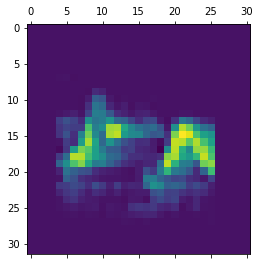

In [10]:
plt.matshow(np.squeeze(X_labeled[0]))

### Build network

In [11]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.layers import (
    Conv2D,
    Reshape,
    Bidirectional,
    Dense,
    RepeatVector,
    TimeDistributed,
    LSTM
)
n_components=2

In [12]:
input_shape = dims

In [13]:
lr_alpha = 0.1
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
model.add(Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ))
model.add(
Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    )
)
model.add(
Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    )
)
model.add(
Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    )
)
model.add(Reshape(target_shape=(8, 2*128)))
model.add(Bidirectional(LSTM(units=100, activation="relu")))
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name="lrelufc1"))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name="lrelufc2"))
model.add(
        WeightNormalization(layers.Dense(num_classes, activation=None), name="y_")
    )

W1111 17:58:45.211405 140044905572096 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W1111 17:58:45.219709 140044905572096 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W1111 17:58:45.228703 140044905572096 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 8, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 8, 128)         147584    
_________________________________________________________________
reshape (Reshape)            (None, 8, 256)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               285600    
_________________________________________________________________
z (Dense)                    (None, 256)               5

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)

In [16]:
import tensorflow_addons as tfa

In [17]:
opt = tf.keras.optimizers.Adam(1e-4)
opt = tfa.optimizers.MovingAverage(opt)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(opt, loss = loss, metrics=['accuracy'])

In [18]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [19]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [20]:
from livelossplot import PlotLossesKerasTF
# plot losses callback
plotlosses = PlotLossesKerasTF()

In [21]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
    .repeat()
    .shuffle(len(X_labeled))
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

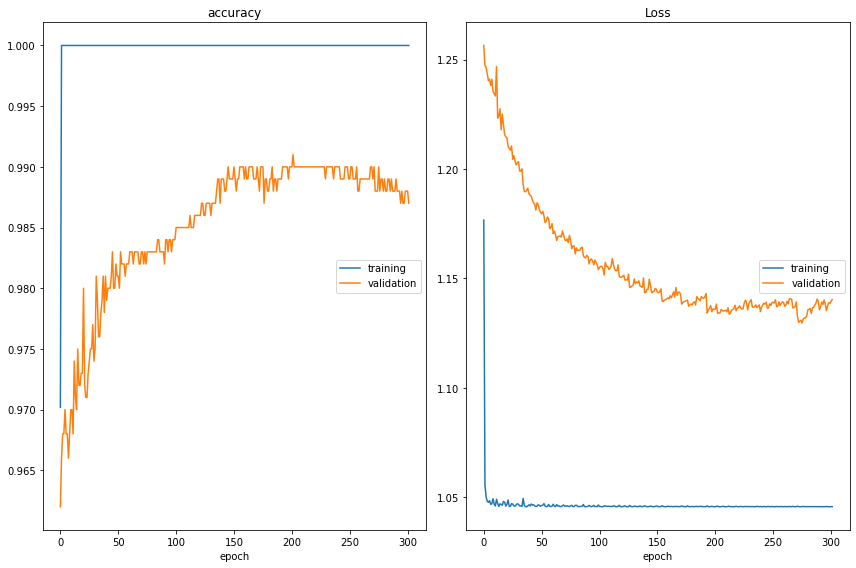

accuracy
	training         	 (min:    0.970, max:    1.000, cur:    1.000)
	validation       	 (min:    0.962, max:    0.991, cur:    0.987)
Loss
	training         	 (min:    1.046, max:    1.177, cur:    1.046)
	validation       	 (min:    1.130, max:    1.256, cur:    1.140)
195/195 [==============================] - 11s 58ms/step - loss: 1.0457 - accuracy: 1.0000 - val_loss: 1.1403 - val_accuracy: 0.9870
Epoch 00302: early stopping


In [22]:
steps_per_epoch = int(len(X_train)/ batch_size)

history = model.fit(
    train_ds,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping, plotlosses],
    steps_per_epoch = steps_per_epoch,
)

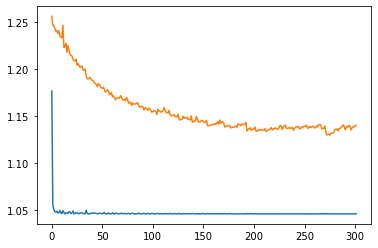

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

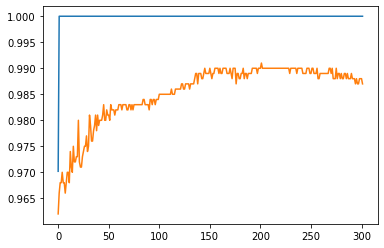

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [25]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(24984, 256)

In [26]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Wed Nov 11 18:54:22 2020 Finding Nearest Neighbors
Wed Nov 11 18:54:22 2020 Building RP forest with 13 trees
Wed Nov 11 18:54:29 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Wed Nov 11 18:54:43 2020 Finished Nearest Neighbor Search
Wed Nov 11 18:54:47 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Nov 11 18:55:01 2020 Finished embedding


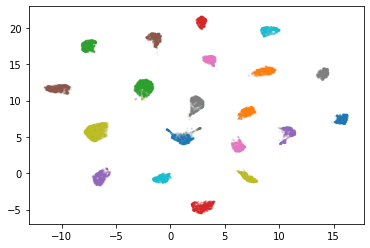

In [27]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Wed Nov 11 18:55:03 2020 Finding Nearest Neighbors
Wed Nov 11 18:55:06 2020 Finished Nearest Neighbor Search
Wed Nov 11 18:55:07 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Nov 11 18:55:12 2020 Finished embedding


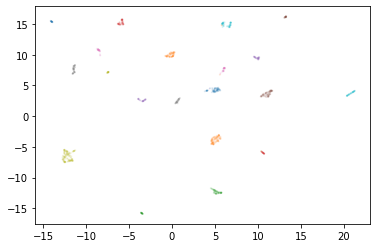

In [28]:
z_valid = submodel.predict(X_valid)
np.shape(z_valid)
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z_valid.reshape(len(z_valid), np.product(np.shape(z_valid)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

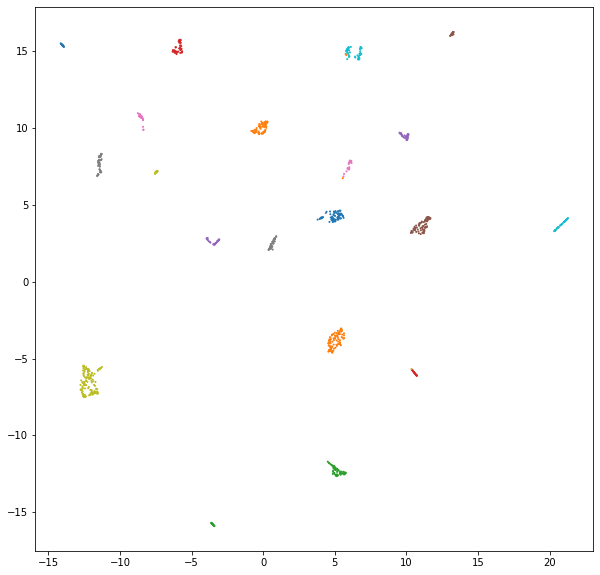

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [30]:
predictions = model.predict(X_valid)

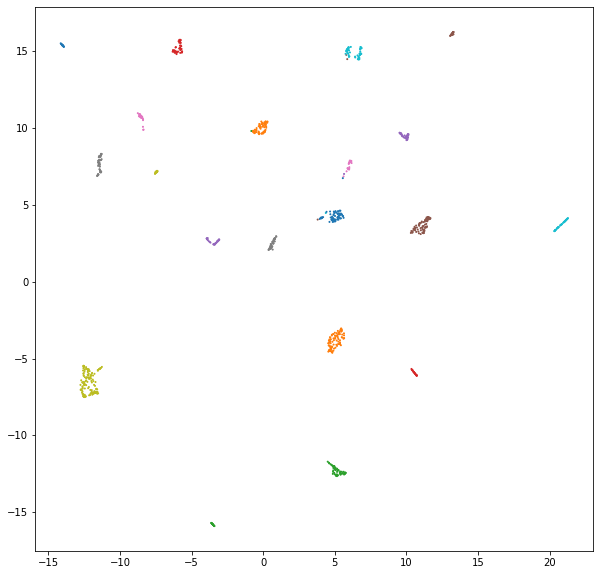

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [32]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

32/32 [==============================] - 0s 7ms/step - loss: 1.1392 - accuracy: 0.9920


### save results

In [33]:
# save score, valid embedding, weights, results

In [34]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [35]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [36]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [37]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [38]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

['input_2', 'weight_normalization', 'lrelufc1', 'weight_normalization_1', 'lrelufc2', 'y_']


In [39]:
classifier.save_weights((save_folder / "classifier").as_posix())

#### save score

In [40]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

32/32 [==============================] - 0s 7ms/step - loss: 1.1392 - accuracy: 0.9920


In [41]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [42]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Wed Nov 11 18:55:23 2020 Finding Nearest Neighbors
Wed Nov 11 18:55:23 2020 Building RP forest with 13 trees
Wed Nov 11 18:55:24 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Wed Nov 11 18:55:25 2020 Finished Nearest Neighbor Search
Wed Nov 11 18:55:26 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Nov 11 18:55:40 2020 Finished embedding


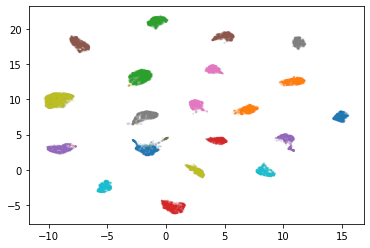

In [43]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [44]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [45]:
import pickle

In [46]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)